In [1]:
# Import Libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn import metrics

warnings.simplefilter('ignore')

### Data Preparation

In [2]:
# Create a wrangle function for data cleaning
def wrangle (filepath):
    df = pd.read_csv(filepath)
    
    # Remove duplicate rows
    df = df.drop_duplicates()
    
    # Remove 'TotalCharges' Column due to its high colinearity with Tenure
    df.drop('TotalCharges', axis = 1, inplace = True)
    return df

In [3]:
# Import and Wrangle CSV file
df = wrangle(r"C:\Users\GREAT\Downloads\Telco_Customer_Churn_Dataset  (3) - Telco_Customer_Churn_Dataset  (3).csv")
print(df.shape)
df.head()

(7043, 20)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes


In [4]:
# Inspect data after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# Check Unique values in each column
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
Churn                  2
dtype: int64

In [6]:
# Drop customerID column
df.drop(columns = ['customerID'], axis = 1, inplace = True)
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'Churn'],
      dtype='object')

In [7]:
# Convert 'SeniorCitizen' column back to a binary column
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [8]:
#  Binary Columns List
bin_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']

# Categorical Columns List
cat_cols = ['InternetService', 'Contract', 'PaymentMethod','PhoneService', 'MultipleLines',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Numerical Columns List
num_cols = ['tenure', 'MonthlyCharges']

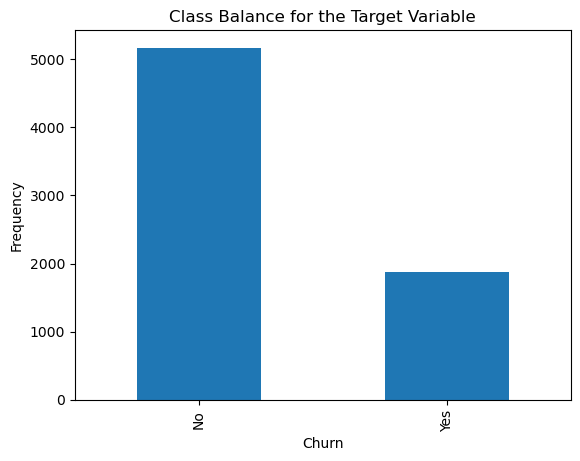

In [9]:
# Class Balance
df['Churn'].value_counts().plot(
    kind = 'bar',
    ylabel = 'Frequency',
    title = 'Class Balance for the Target Variable'
);

###  Data Preprocessing

In [10]:
# Label Encode binary columns
le = LabelEncoder()
for col in bin_cols:
    df[col] = le.fit_transform(df[col])

# One Hot Encode Categorical Columns
df = pd.get_dummies(df, columns = cat_cols, drop_first = True)

# Covert Booleans to Numbers
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

#Inpect final dataset
pd.set_option('display.max_columns',100)
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,0,1,0,1,1,29.85,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,34,0,56.95,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


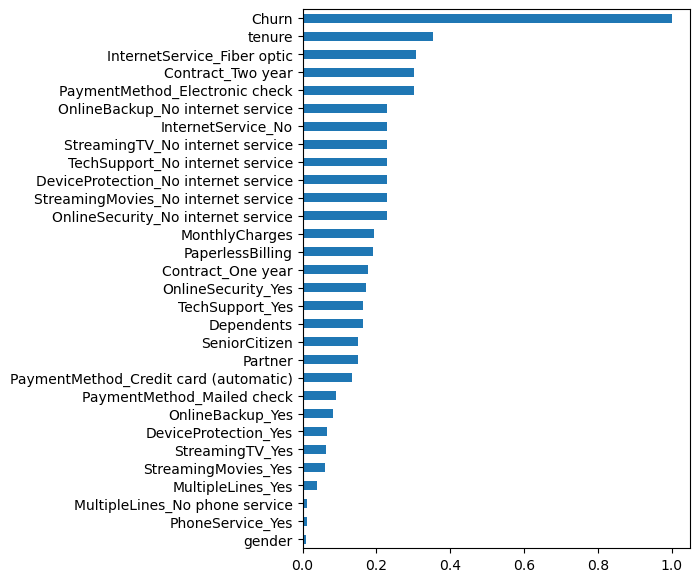

In [11]:
# Correlation with Churn
corr = np.abs(df.corr())
plt.figure(figsize = (5,7))
corr['Churn'].sort_values().plot(kind = 'barh');

In [12]:
corr['Churn'].sort_values(ascending = False)

Churn                                    1.000000
tenure                                   0.352229
InternetService_Fiber optic              0.308020
Contract_Two year                        0.302253
PaymentMethod_Electronic check           0.301919
OnlineBackup_No internet service         0.227890
StreamingMovies_No internet service      0.227890
OnlineSecurity_No internet service       0.227890
StreamingTV_No internet service          0.227890
InternetService_No                       0.227890
DeviceProtection_No internet service     0.227890
TechSupport_No internet service          0.227890
MonthlyCharges                           0.193356
PaperlessBilling                         0.191825
Contract_One year                        0.177820
OnlineSecurity_Yes                       0.171226
TechSupport_Yes                          0.164674
Dependents                               0.164221
SeniorCitizen                            0.150889
Partner                                  0.150448


```There is a very high correlation (0.99) between 'InternetService_No' and all the '_No internet Service' features. We will pick just one feature (InternetService_No) for our model training to reduce noise```

### SPLIT

In [13]:
# Define Features and Target 
target = 'Churn'
X = df[['tenure', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check',
        'InternetService_No', 'MonthlyCharges', 'PaperlessBilling','OnlineSecurity_Yes', 'Contract_One year', 
        'TechSupport_Yes', 'Dependents', 'SeniorCitizen', 'Partner']]
y = df[target]

# Train Test Split
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2,random_state = 42)
print(X_train.shape, X_test.shape,y_train.shape,y_test.shape)

# Handle Class Imbalance
sm = SMOTE(random_state = 42)
X_train_over, y_train_over = sm.fit_resample(X_train,y_train)
print(X_train_over.shape, X_test.shape,y_train_over.shape,y_test.shape)

(5634, 13) (1409, 13) (5634,) (1409,)
(8276, 13) (1409, 13) (8276,) (1409,)


In [14]:
# Standardize 'tenure' and 'monthly charges columns'
scaler = StandardScaler()
X_train_over[['tenure','MonthlyCharges']] = scaler.fit_transform(X_train_over[['tenure','MonthlyCharges']])
X_test[['tenure','MonthlyCharges']] = scaler.fit_transform(X_test[['tenure','MonthlyCharges']])

#### Build Model

#### Baseline Accuracy

In [15]:
# Determine baseline accuracy
acc_baseline = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', round(acc_baseline,2))

Baseline Accuracy: 0.73


In [16]:
# Instantiate models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Xgboost': xgb.XGBClassifier(random_state = 42)
}

# Train models on oversampled training data
for name, model in models.items():
    model.fit(X_train_over, y_train_over)
    print(f"{name} model trained successfully")

Logistic Regression model trained successfully
Decision Tree model trained successfully
Random Forest model trained successfully
Xgboost model trained successfully


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1036
           1       0.51      0.83      0.63       373

    accuracy                           0.74      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409



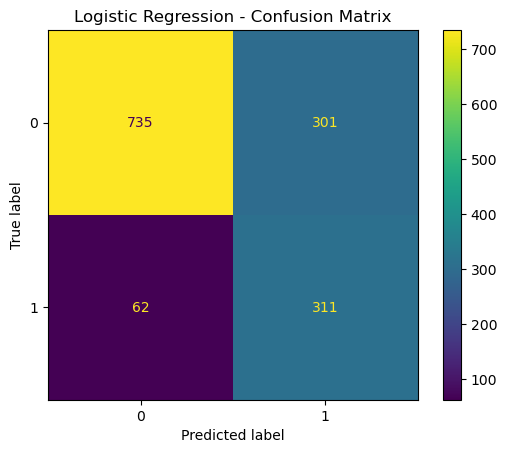

Decision Tree Classification Report
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1036
           1       0.47      0.59      0.52       373

    accuracy                           0.71      1409
   macro avg       0.65      0.67      0.66      1409
weighted avg       0.74      0.71      0.72      1409



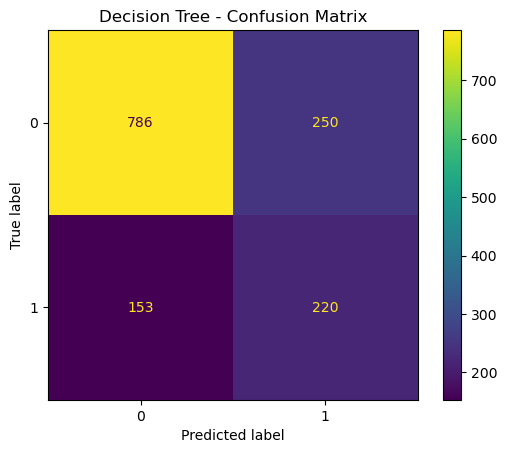

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1036
           1       0.55      0.62      0.58       373

    accuracy                           0.76      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.77      0.76      0.77      1409



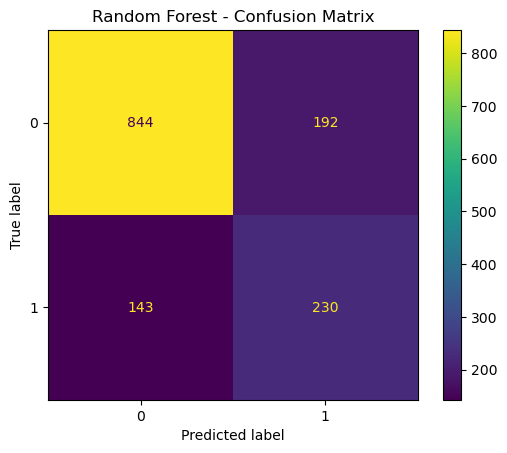

Xgboost Classification Report
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1036
           1       0.53      0.70      0.61       373

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



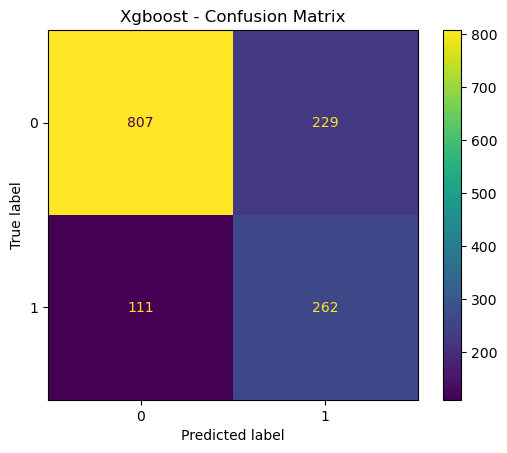

In [17]:
for name, model in models.items():
    print(f"{name} Classification Report")
    y_pred = model.predict(X_test)
    
    # Classification report
    print(metrics.classification_report(y_test, y_pred))
    
    # Confusion matrix
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test)
    plt.title(f"{name} - Confusion Matrix")
    plt.show();

Top 10 Features - Logistic Regression
Contract_Two year     2.070814
Contract_One year     1.364432
OnlineSecurity_Yes    1.073288
TechSupport_Yes       1.045562
InternetService_No    0.786674
Dependents            0.734302
MonthlyCharges        0.696865
SeniorCitizen         0.444762
tenure                0.423903
Partner               0.352248
dtype: float64


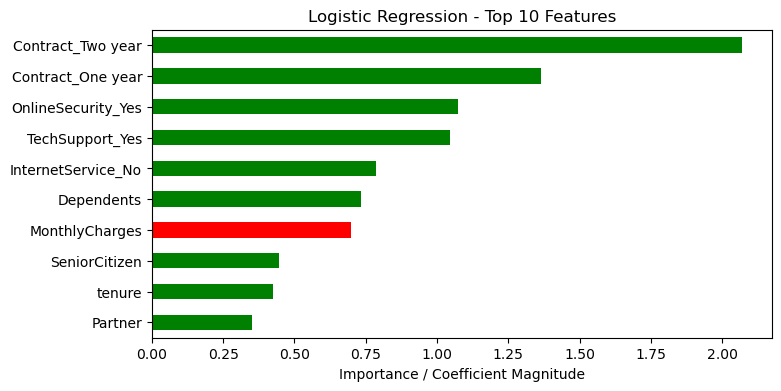

Top 10 Features - Decision Tree
MonthlyCharges                    0.301617
tenure                            0.203301
Contract_Two year                 0.161371
Contract_One year                 0.131005
InternetService_Fiber optic       0.032289
PaymentMethod_Electronic check    0.030125
PaperlessBilling                  0.029086
OnlineSecurity_Yes                0.028225
Dependents                        0.026669
TechSupport_Yes                   0.019378
dtype: float64


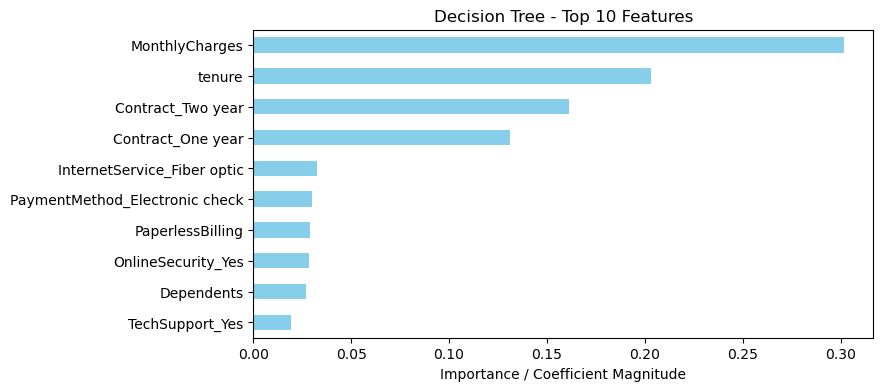

Top 10 Features - Random Forest
MonthlyCharges                 0.328349
tenure                         0.254267
Contract_Two year              0.083536
Contract_One year              0.057034
OnlineSecurity_Yes             0.047623
InternetService_Fiber optic    0.043779
TechSupport_Yes                0.038062
Dependents                     0.037028
Partner                        0.029248
InternetService_No             0.026130
dtype: float64


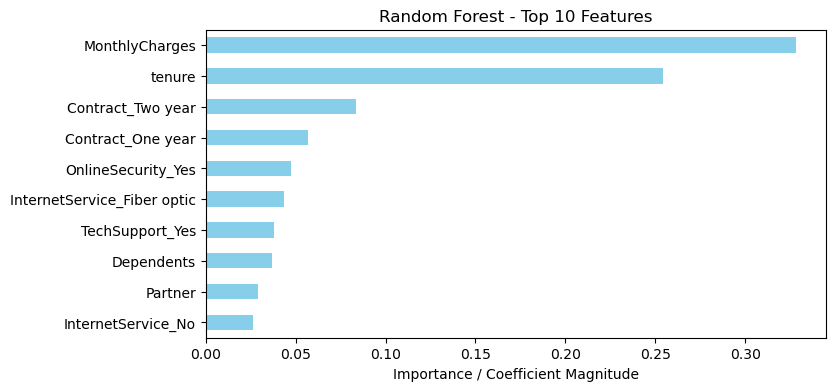

Top 10 Features - Xgboost
Contract_Two year              0.425672
Contract_One year              0.195206
InternetService_No             0.105792
InternetService_Fiber optic    0.105317
OnlineSecurity_Yes             0.038880
TechSupport_Yes                0.029273
Dependents                     0.023317
SeniorCitizen                  0.014865
tenure                         0.014722
MonthlyCharges                 0.013425
dtype: float32


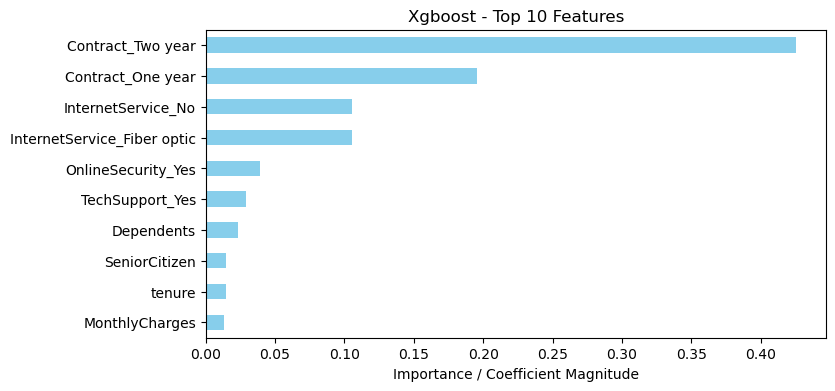

In [18]:
feature_importances = {}

for name, model in models.items():
    # Get feature importance or coefficient magnitudes
    if hasattr(model, "feature_importances_"): 
        importances = model.feature_importances_
    else:  
        importances = np.abs(model.coef_[0])
        # Get direction for coloring
        directions = ['Risk' if c > 0 else 'Protective' for c in model.coef_[0]]

    # Store in dictionary
    feature_importances[name] = pd.Series(importances, index=X_train_over.columns).sort_values(ascending=False)

    # Display top 10 features
    top_features = feature_importances[name].head(10)
    print(f"Top 10 Features - {name}")
    print(top_features)

    # Plot with colors
    plt.figure(figsize=(8,4))
    
    if hasattr(model, "feature_importances_"):  # Trees
        top_features.plot(kind='barh', color='skyblue')
    else:  # Logistic Regression
        # Get colors for top 10 features
        top_colors = ['green' if c < 0 else 'red' for c in model.coef_[0][np.argsort(-np.abs(model.coef_[0]))[:10]]]
        top_features.plot(kind='barh', color=top_colors)
    
    plt.gca().invert_yaxis()
    plt.title(f"{name} - Top 10 Features")
    plt.xlabel("Importance / Coefficient Magnitude")
    plt.show()

In [19]:
# Hyperparameter tuning for all models
param_grids = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state = 42, max_iter = 1000),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "solver": ["lbfgs", "liblinear", "saga"],
            "penalty": ["l2", "l1"]
        }
    },
    "Decision Tree": {
    "model": DecisionTreeClassifier(random_state=42),
    "params": {
        "criterion": ["gini", "entropy"],              
        "max_depth": [3, 5, 10, 20, None],      
        "min_samples_split": [2, 5, 10],           
        "min_samples_leaf": [1, 2, 4],           
        "max_features": ["sqrt", "log2", None]        
        }
    },
    "Random Forest": {
    "model": RandomForestClassifier(random_state=42),
    "params": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2]
       }
   },
    "XGBoost": {
    "model": xgb.XGBClassifier(random_state=42),
    "params": {
        "objective": ['binary:logistic'], 
        "n_estimators": [100, 200],
        "learning_rate": [0.01, 0.1, 0.2], 
        "max_depth": [3,5],
        "subsample": [0.7, 1.0],
        "colsample_bytree": [0.7, 1.0]
        }
    }
}

In [ ]:
# RunHyperparameterTuning
best_models = {}

for name, mp in param_grids.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(estimator = mp["model"], param_grid = mp["params"], scoring = "roc_auc", cv = 5, n_jobs = -1, verbose = 1)
    grid.fit(X_train_over, y_train_over)
    
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"Best roc_auc: {grid.best_score_:.2f}\n")
    
    best_models[name] = grid.best_estimator_

Tuning Logistic Regression...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best roc_auc: 0.86

Tuning Decision Tree...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Best params for Decision Tree: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best roc_auc: 0.85

Tuning Random Forest...
Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
# EvaluateTunedModels
for name, model in best_models.items():
    print(f"\n{name} - Tuned Model Performance")
    y_pred = model.predict(X_test)
    print(metrics.classification_report(y_test, y_pred))
    
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Blues')
    plt.title(f"{name} - Confusion Matrix (Tuned)")
    plt.show()

In [ ]:
   # Loop through each model to compute ROC and AUC
for name, model in best_models.items():
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # for class 1
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw = 2, label = f'{name} (AUC = {roc_auc:.3f})')

# Plot random guess line
plt.plot([0,1], [0,1], color = 'red', lw = 2, linestyle = '--', label = 'Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc = 'lower right')
plt.grid(True);

**The ROC curves concludes that Logistic Regression (AUC = 0.86) is the best model for identifying at-risk customers, based on its recall and AUC value**